In [1]:
# There is currently an incompatibility in the code completion (https://stackoverflow.com/a/65862512/227081) that can be circumvented by disabling the jedi code completion
%config Completer.use_jedi = False

In [30]:
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [35]:
!pip freeze

absl-py==2.0.0
anyio==4.0.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.2.3
asttokens==2.4.0
astunparse==1.6.3
async-lru==2.0.4
attrs==23.1.0
Babel==2.12.1
backcall==0.2.0
beautifulsoup4==4.12.2
bleach==6.0.0
blinker==1.4
cachetools==5.3.1
certifi==2023.7.22
cffi==1.15.1
charset-normalizer==3.2.0
comm==0.1.4
contourpy==1.1.1
cryptography==3.4.8
cycler==0.11.0
dbus-python==1.2.18
debugpy==1.8.0
decorator==5.1.1
defusedxml==0.7.1
distro==1.7.0
executing==1.2.0
fastjsonschema==2.18.0
flatbuffers==23.5.26
fonttools==4.42.1
fqdn==1.5.1
gast==0.5.4
google-auth==2.23.1
google-auth-oauthlib==1.0.0
google-pasta==0.2.0
grpcio==1.58.0
h5py==3.9.0
httplib2==0.20.2
idna==3.4
importlib-metadata==4.6.4
ipykernel==6.25.2
ipython==8.15.0
ipython-genutils==0.2.0
ipywidgets==8.1.1
isoduration==20.11.0
jedi==0.19.0
jeepney==0.7.1
Jinja2==3.1.2
json5==0.9.14
jsonpointer==2.4
jsonschema==4.19.1
jsonschema-specifications==2023.7.1
jupyter==1.0.0
jupyter-console==6.6.3
jupyter-events==0.7.0
jupy

In [34]:
import pathlib
import pandas as pd
import PIL
import PIL.Image
import tensorflow as tf
import numpy as np

ModuleNotFoundError: No module named 'pandas'

In [3]:
tf.config.list_physical_devices('GPU')

2023-10-27 20:32:05.023101: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-27 20:32:05.026717: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-27 20:32:05.026742: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
data_dir=pathlib.Path('/project/training_data')

In [5]:
len(list(data_dir.glob('*/*.png')))

169

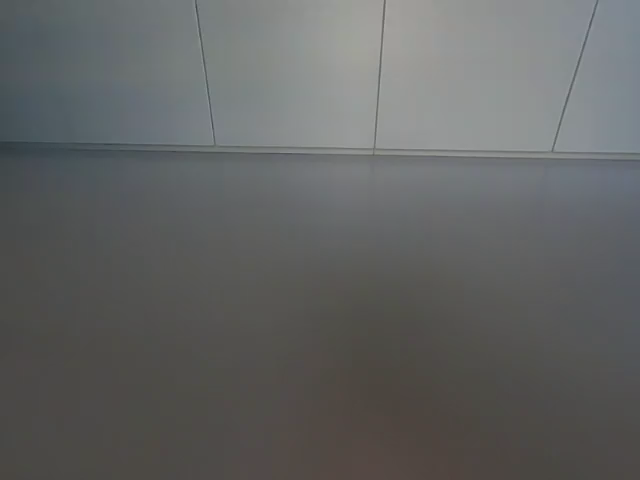

In [6]:
danger = list(data_dir.glob('danger/*.png'))
safe = list(data_dir.glob('safe/*.png'))
image = PIL.Image.open(str(safe[0]))
image

In [7]:
image.size

(640, 480)

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=432,
    image_size=(180,180),
    batch_size=16)

Found 169 files belonging to 2 classes.
Using 136 files for training.


2023-10-27 20:32:05.471205: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-27 20:32:05.471266: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-27 20:32:05.471283: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-27 20:32:05.667482: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-27 20:32:05.667525: I tensorflow/compile

In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=432,
    image_size=(180,180),
    batch_size=16)

Found 169 files belonging to 2 classes.
Using 33 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['danger', 'safe']


Matplotlib created a temporary cache directory at /tmp/matplotlib-l0v3q2gc because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


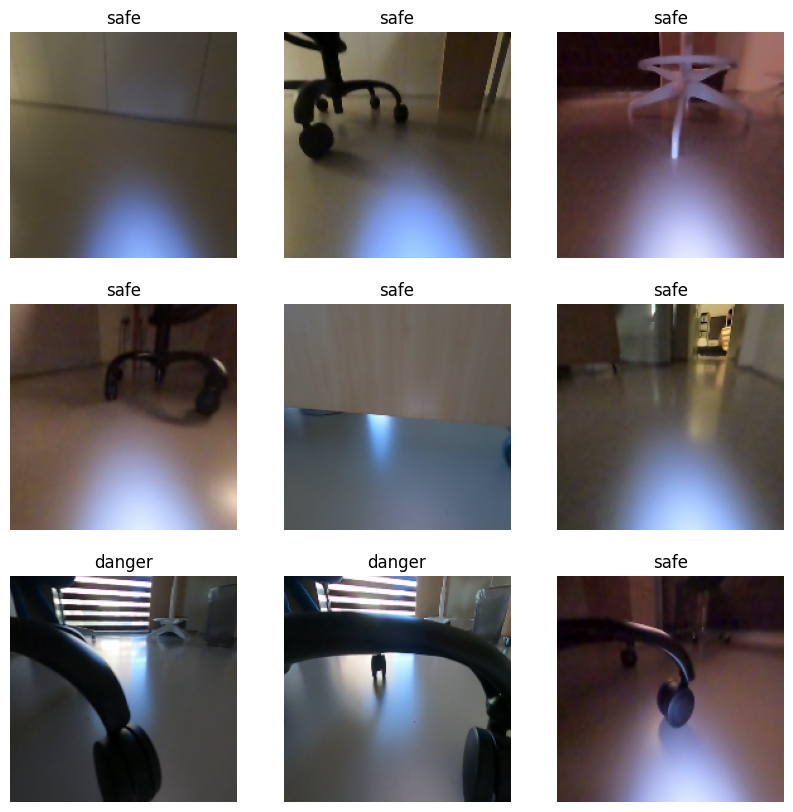

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(16, 180, 180, 3)
(16,)


In [13]:
# https://www.tensorflow.org/tutorials/load_data/images#configure_the_dataset_for_performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [14]:
num_classes = len(class_names)

# random example, but notice the first Rescaling layer. That one will make sure the data is in
# the prefered 0-1 range, instead of 0-255
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


In [15]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [25]:
history = model.fit(train_ds, validation_data=val_ds, epochs=50)

Epoch 1/50
9/9 [==============================] - 0s 20ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.3467 - val_accuracy: 0.9394
Epoch 2/50
9/9 [==============================] - 0s 9ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.3036 - val_accuracy: 0.9394
Epoch 3/50
9/9 [==============================] - 0s 10ms/step - loss: 9.4867e-04 - accuracy: 1.0000 - val_loss: 0.3133 - val_accuracy: 0.9394
Epoch 4/50
9/9 [==============================] - 0s 9ms/step - loss: 6.4020e-04 - accuracy: 1.0000 - val_loss: 0.3453 - val_accuracy: 0.9394
Epoch 5/50
9/9 [==============================] - 0s 10ms/step - loss: 4.8427e-04 - accuracy: 1.0000 - val_loss: 0.3456 - val_accuracy: 0.9394
Epoch 6/50
9/9 [==============================] - 0s 9ms/step - loss: 3.8337e-04 - accuracy: 1.0000 - val_loss: 0.3401 - val_accuracy: 0.9394
Epoch 7/50
9/9 [==============================] - 0s 8ms/step - loss: 3.2632e-04 - accuracy: 1.0000 - val_loss: 0.3453 - val_accuracy: 0.9394
Epoch 8/50


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 32)        9

In [18]:
list(train_ds.enumerate())[0]

2023-10-27 20:32:13.028927: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


(<tf.Tensor: shape=(), dtype=int64, numpy=0>,
 (<tf.Tensor: shape=(16, 180, 180, 3), dtype=float32, numpy=
  array([[[[ 48.72222  ,  41.72222  ,  19.722221 ],
           [ 92.63889  ,  85.63889  ,  63.63889  ],
           [129.50926  , 122.50926  ,  98.50926  ],
           ...,
           [ 36.166668 ,  31.166666 ,  13.166667 ],
           [ 32.02776  ,  27.027761 ,   9.0277605],
           [ 32.333332 ,  27.333334 ,   9.333333 ]],
  
          [[ 24.222221 ,  21.222221 ,   7.7222223],
           [ 24.666668 ,  21.666668 ,   8.166667 ],
           [ 47.80556  ,  44.805557 ,  29.30556  ],
           ...,
           [ 33.888855 ,  28.888855 ,  12.888855 ],
           [ 29.666626 ,  24.666626 ,   6.666626 ],
           [ 26.138885 ,  21.138885 ,   3.1388855]],
  
          [[ 16.833336 ,  14.833335 ,  11.833335 ],
           [ 17.944447 ,  15.944445 ,  12.944446 ],
           [ 18.481482 ,  17.481482 ,   9.481482 ],
           ...,
           [ 32.898144 ,  26.898142 ,  12.898142 ],
     

In [19]:
image = PIL.Image.open(str(safe[0]))
test_input = tf.expand_dims(tf.constant(image.resize((180,180))), axis=0)

In [20]:
test_input.shape

TensorShape([1, 180, 180, 3])

In [21]:
pred = model.predict(test_input)
pred

1/1 [==============================] - 0s 63ms/step


array([[-5.949369,  3.043755]], dtype=float32)

In [22]:
class_names[np.argmax(pred)]

'safe'

1/1 [==============================] - 0s 13ms/step


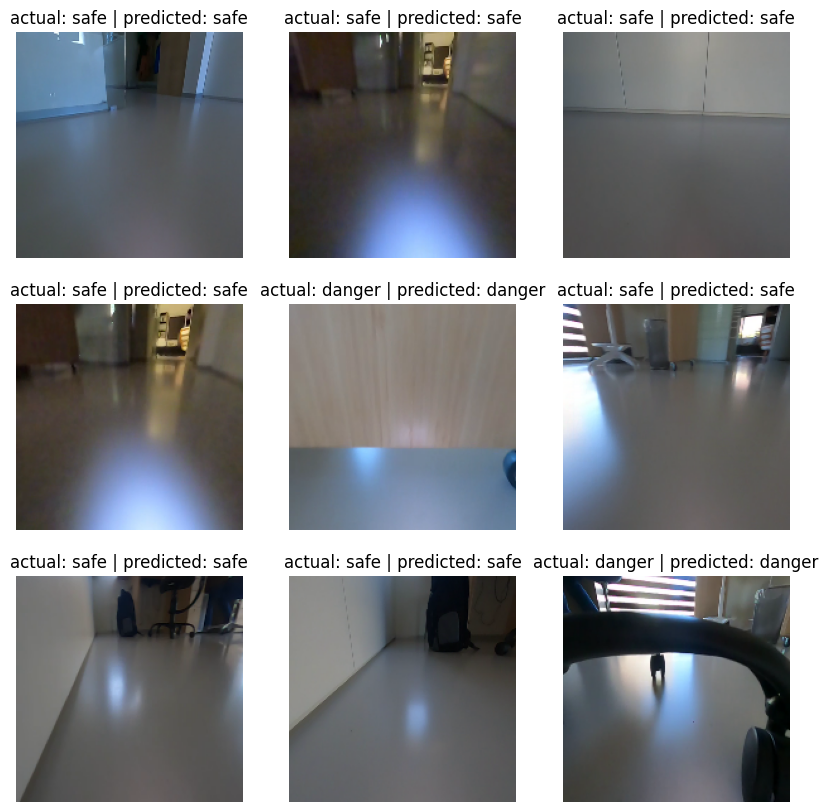

In [23]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.shuffle(16).take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    pred = model.predict(tf.expand_dims(images[i], axis=0))
    label = class_names[np.argmax(pred)]
    plt.title(f'actual: {class_names[labels[i]]} | predicted: {label}')
    plt.axis("off")

In [24]:
model.save('/project/saved_models/first_model.keras')